# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

## Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

## Project Initialization

Before we start our project, let's import the packages that we'll use and datasets that Starbucks + Udacity has provided for us.

In [1]:
#Importing everything we'll need

#General Packages
import math
import json
import os
import datetime
from tqdm import tqdm
import itertools
# !pip install lifelines
import lifelines

#Data Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

#Sklearn Packages
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
from sklearn.metrics import fbeta_score, accuracy_score

# !pip install shap                                                                                                                                                                                                                                                                                         
import shap

#Magic Commands
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Reading in the json files
portfolio = pd.read_json('data/portfolio.json', orient = 'records', lines = True)
profile = pd.read_json('data/profile.json', orient = 'records', lines = True)
transcript = pd.read_json('data/transcript.json', orient = 'records', lines = True)

## Initial Analysis

With our packages and data imported, we'll build a shallow analysis for each of our three datasets to understand better how win our challenge.

### Portfolio Dataset

#### Initial Analysis

In [3]:
#Looking at the first five rows of the portfolio dataset
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [4]:
#Looking at the completeness of portfolio dataset
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [5]:
#Viewing all the offer_types that are offered
portfolio['offer_type'].value_counts()

discount         4
bogo             4
informational    2
Name: offer_type, dtype: int64

In [6]:
#Viewing all the channels leveraged
#We need to convert channels to tuple to be able to count the values with value_counts
portfolio['channels'].apply(tuple).value_counts()

(web, email, mobile, social)    4
(web, email, mobile)            3
(email, mobile, social)         2
(web, email)                    1
Name: channels, dtype: int64

#### Portfolio Clean Up

Some caracteristics of dataset will be changed to make our job better:

- Change the column name 'id' to 'offer_id' to be more descriptive and mergeable with our other datasets
- One hot encode the 'offer_type' column. It will be used with our algorithms later
- Split and one hot encode the 'channels' column
- Drop 'offer_type' and 'channels' columns now that they are one hot encoded

In [7]:
#Changing the column name from 'id' to 'offer_id'
portfolio.rename(columns = {'id': 'offer_id'}, inplace = True)
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   offer_id    10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [8]:
#One hot encoding the offer_type field, fixing a prefix of 'offer'
offer_dummies = pd.get_dummies(portfolio['offer_type'], prefix = 'offer')
portfolio = pd.concat([portfolio, offer_dummies], axis = 1)
portfolio.head()

,reward,channels,difficulty,duration,offer_type,offer_id,offer_bogo,offer_discount,offer_informational
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,0,0,1
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0


In [9]:
#Spliting and one hot encoding the channels field
#font: https://chrisalbon.com/machine_learning/preprocessing_structured_data/one-hot_encode_features_with_multiple_labels/

#Initializing our MultiLabelBinarizer object
channels_one_hot = MultiLabelBinarizer()

#One hot encoding the data
sep_channels = channels_one_hot.fit_transform(portfolio['channels'])

#Building a DataFrame around these channels
channels_df = pd.DataFrame(data = sep_channels, columns = channels_one_hot.classes_)

#Concatenating the new columns to our primary 'portfolio' DataFrame
portfolio = pd.concat([portfolio, channels_df], axis = 1)

#Changing the column names to affix 'channels_' prefix
portfolio.rename(columns = {'email': 'channel_email', 'mobile': 'channel_mobile', 'social': 'channel_social', 'web': 'channel_web'}, inplace = True)

#Viewing our changes
portfolio.head()

,reward,channels,difficulty,duration,offer_type,offer_id,offer_bogo,offer_discount,offer_informational,channel_email,channel_mobile,channel_social,channel_web
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0,1,1,1,0
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0,1,1,1,1
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,0,0,1,1,1,0,1
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,1,1,0,1
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,1,0,0,1


In [10]:
#Dropping 'channels' and 'offer_type' columns
portfolio.drop(columns = ['channels'], axis = 1, inplace = True)

#Viewing our hanges
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   reward               10 non-null     int64 
 1   difficulty           10 non-null     int64 
 2   duration             10 non-null     int64 
 3   offer_type           10 non-null     object
 4   offer_id             10 non-null     object
 5   offer_bogo           10 non-null     uint8 
 6   offer_discount       10 non-null     uint8 
 7   offer_informational  10 non-null     uint8 
 8   channel_email        10 non-null     int32 
 9   channel_mobile       10 non-null     int32 
 10  channel_social       10 non-null     int32 
 11  channel_web          10 non-null     int32 
dtypes: int32(4), int64(3), object(2), uint8(3)
memory usage: 718.0+ bytes


### Profile Dataset

#### Initial Analysis

In [11]:
#Looking at the first five rows
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [12]:
#Checking for data completeness
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [13]:
#Cheking gender types and the nulls
profile['gender'].value_counts(dropna = False)

M      8484
F      6129
NaN    2175
O       212
Name: gender, dtype: int64

In [14]:
#Checking how many unknown ages (118) are in the dataset
(profile['age'] == 118).sum()

2175

#### Profile Clean Up

As this dataset is bigger than the other one, we'll have to make some more changes to it as following:

 - Dropping rows with null information, in my opinion the dataset is big enougth without null values to take the risk trying use some method of fill null values
 - Changing 'id' column to 'customer_id' 
 - Cast the 'became_member_on' column to a date object type
 - Calculating number of days that a person has been a member as new 'days_as_member' column
 - Creating new 'age_range' column based on 'age'

In [15]:
#Dropping null rows
profile.dropna(inplace = True)
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               14825 non-null  int64  
 2   id                14825 non-null  object 
 3   became_member_on  14825 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 694.9+ KB


In [16]:
#Changing 'id' column to 'customer_id'
profile.rename(columns = {'id': 'customer_id'}, inplace = True)
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               14825 non-null  int64  
 2   customer_id       14825 non-null  object 
 3   became_member_on  14825 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 694.9+ KB


In [17]:
#Changing 'became_member_on' column to a date type
profile['became_member_on'] = profile['became_member_on'].apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d').date())
profile['became_member_on'].head()

1     2017-07-15
3     2017-05-09
5     2018-04-26
8     2018-02-09
12    2017-11-11
Name: became_member_on, dtype: object

In [18]:
#Calculating number of days as a member ending on August 1, 2018 in new column 'days_as_member'
#font: https://stackoverflow.com/questions/26072087/pandas-number-of-days-elapsed-since-a-certain-date
end_date = pd.Timestamp('2018-08-01')
end_date = pd.to_datetime(end_date)
profile['days_as_member'] = np.abs((pd.to_datetime(profile['became_member_on']) - end_date).dt.days)

#Viewing results
profile['days_as_member'].head(10)

1      382
3      449
5       97
8      173
12     263
13     324
14    1630
15     902
16    1357
18     213
Name: days_as_member, dtype: int64

In [19]:
#Creating 'age_range' 
#font: https://stackoverflow.com/questions/52753613/grouping-categorising-ages-column-in-python-pandas
age_range_labels = ['11-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
age_range_bins = [11, 20, 30, 40, 50, 60, 70, 80, 110]
profile['age_range'] = pd.cut(profile['age'], bins = age_range_bins, labels = age_range_labels, right = False)

#Adding a specific order to the age_range_field
#font: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Categorical.html
profile['age_range'] = pd.Categorical(profile['age_range'], ordered = True, categories = age_range_labels)

#Testing our results
profile.sample(5)

,gender,age,customer_id,became_member_on,income,days_as_member,age_range
9670,F,66,73d249175a594096b82528817cb483db,2017-06-25,90000.0,402,60-69
3189,M,34,00ceaf16a40341e6996d543d04daa2c2,2018-05-19,38000.0,74,30-39
1854,M,34,fbd07f6b2ebd48c2b2a7dc96e244deb5,2014-09-05,36000.0,1426,30-39
1784,M,47,0414fcebbd7f4a19bca352622b1c84e2,2018-01-15,44000.0,198,40-49
3376,M,54,970c64a67acb4bd7a8f357d3ba4fbec1,2017-10-07,69000.0,298,50-59


### Transcript Dataset

#### Initial Analysis

In [20]:
#Looking at the first five rows
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [21]:
#Checking for null values and datatypes
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [22]:
#Checking out the event types
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

#### Transcript Clean Up
Some changes in transcipt dataset:
 - Change name of 'person' column to 'customer_id'
 - Remove customers that are not reflected in the 'profile' dataset
 - One hot encode the 'event' values
 - Change 'time' column to 'days' 
 - Split value from key in 'value' dictionary to two new DataFrames: transcript_offer and transcript_amount

In [23]:
#Changing the 'person' category name to 'customer_id'
transcript.rename(columns = {'person': 'customer_id'}, inplace = True)
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   customer_id  306534 non-null  object
 1   event        306534 non-null  object
 2   value        306534 non-null  object
 3   time         306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [24]:
#Remove customers not found in the 'profile dataset'
transcript = pd.merge(left = transcript, right = profile, how = 'inner', left_on = 'customer_id', right_on = 'customer_id')
transcript.drop(columns = ['age', 'became_member_on', 'gender', 'income', 'days_as_member', 'age_range'], inplace = True)
transcript.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272762 entries, 0 to 272761
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   customer_id  272762 non-null  object
 1   event        272762 non-null  object
 2   value        272762 non-null  object
 3   time         272762 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 10.4+ MB


In [25]:
#One hot encode the 'event' values
event_dummies = pd.get_dummies(transcript['event'])
event_dummies.rename(columns = {'offer completed': 'offer_completed', 'offer received': 'offer_received', 'offer viewed': 'offer_viewed'}, inplace = True)
transcript = pd.concat([transcript, event_dummies], axis = 1)
transcript.head()

,customer_id,event,value,time,offer_completed,offer_received,offer_viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0,1,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6,0,0,1,0
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.89},132,0,0,0,1
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,132,1,0,0,0
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 17.78},144,0,0,0,1


In [26]:
#Change 'time' column to 'days' and drop time
transcript['days'] = transcript['time'] / 24
transcript.drop(columns = ['time'], inplace = True)
transcript.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272762 entries, 0 to 272761
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   customer_id      272762 non-null  object 
 1   event            272762 non-null  object 
 2   value            272762 non-null  object 
 3   offer_completed  272762 non-null  uint8  
 4   offer_received   272762 non-null  uint8  
 5   offer_viewed     272762 non-null  uint8  
 6   transaction      272762 non-null  uint8  
 7   days             272762 non-null  float64
dtypes: float64(1), object(3), uint8(4)
memory usage: 11.4+ MB


In [27]:
#Split value from key in 'value' dictionary to two new DataFrames: transcript_offer and transcript_amount

#Initial separation
transcript['offer-or-amount'] = transcript['value'].apply(lambda x: list(x.keys())[0])
transcript['id-or-amount'] = transcript['value'].apply(lambda x: list(x.values())[0])

#Conforming 'offer id' to read 'offer_id' consistently
trans_offer_dict = {'offer id': 'offer_id'}
transcript['offer-or-amount'].replace(trans_offer_dict, inplace = True)

#Creating the transcript_offer DataFrame
transcript_offer = transcript[transcript['offer-or-amount'] == 'offer_id']
transcript_offer.rename(columns = {'id-or-amount': 'offer_id'}, inplace = True)
transcript_offer.drop(columns = ['event', 'value', 'offer-or-amount', 'transaction'], inplace = True)

#Creating the transcript_amount DataFrame
transcript_amount = transcript[transcript['offer-or-amount'] == 'amount']
transcript_amount.rename(columns = {'id-or-amount': 'amount'}, inplace = True)
transcript_amount.drop(columns = ['event', 'value', 'offer-or-amount', 'offer_completed', 'offer_received', 'offer_viewed'], inplace = True)

transcript_amount.head(10)

,customer_id,transaction,days,amount
2,78afa995795e4d85b5d9ceeca43f5fef,1,5.50,19.89
4,78afa995795e4d85b5d9ceeca43f5fef,1,6.00,17.78
7,78afa995795e4d85b5d9ceeca43f5fef,1,9.25,19.67
8,78afa995795e4d85b5d9ceeca43f5fef,1,10.00,29.72
9,78afa995795e4d85b5d9ceeca43f5fef,1,15.75,23.93
13,78afa995795e4d85b5d9ceeca43f5fef,1,21.25,21.72
16,78afa995795e4d85b5d9ceeca43f5fef,1,22.25,26.56
20,e2127556f4f64592b11af22de27a7932,1,12.00,17.88
21,e2127556f4f64592b11af22de27a7932,1,12.25,21.43
27,e2127556f4f64592b11af22de27a7932,1,21.75,18.42


In [28]:
#expand the dictionary to coulmns 
transcript['offer_id'] = transcript['value'].apply(lambda x: x.get('offer_id'))
transcript['offer id'] = transcript['value'].apply(lambda x: x.get('offer id'))

#move 'offer id' values into 'offer_id'
transcript['offer_id'] = transcript.apply(lambda x : x['offer id'] if x['offer_id'] == None else x['offer_id'], axis=1)
#drop 'offer id' column 
transcript.drop(['offer id' , 'value'] , axis=1, inplace=True)

## Exploratory Data Analysis

Now that we've done an initial analysis and cleaning, let's now do a little more deep analysis. More you know about the data, better is the models.

In [29]:
#Initializing my preferred color choices
my_blue_color = '#4682B4'
my_green_color = '#8FBE00'

### Question 1
#### What are the general age ranges of customers?

When I think about Starbucks, I imagine young people using their devices and drinking coffe. So I'm expecting that we'll see more customers in those younger age ranges like 20's or 30's.

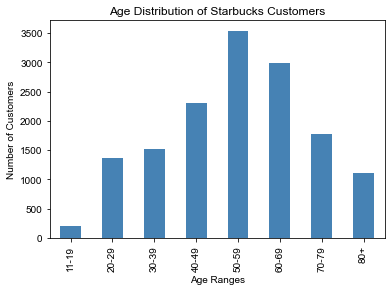

In [30]:
#Viewing the age ranges of Starbucks customers
profile['age_range'].value_counts().sort_index().plot(kind = 'bar', color = my_blue_color);
plt.title('Age Distribution of Starbucks Customers');
plt.style.use('seaborn');
plt.ylabel('Number of Customers');
plt.xlabel('Age Ranges');

### Answer 1: The actual age distributions of Starbucks customers.

I was wrong with my initial assessment. This is example of why it's important to not make assumptions.<br>
The 50-59 and 60-69 has more customers, maybe cause people in this age have a higher wage than the young people. Ok, move on. 

### Question 2: What are the salary ranges of people across different age groups?

Now I'm curious to see how the salary ranges of these various age groups might affect how often a person visits Starbucks and utilizes their rewards program. 
I'm going to guess that those 40-60 age ranges have the highest salary ranges and make more money to show for it.<br>
I'll use <b>violin plot</b> and <b>scatter plot</b> to investigate it.

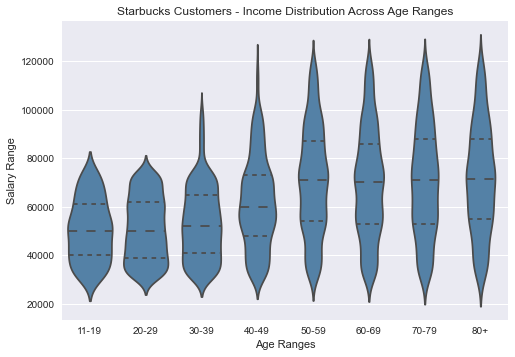

In [31]:
#Visiualizing the data in a violin plot
sb.violinplot(data = profile, x = 'age_range', y = 'income', color = my_blue_color, inner = 'quartile');
plt.title('Starbucks Customers - Income Distribution Across Age Ranges');
plt.xlabel('Age Ranges');
plt.ylabel('Salary Range');
plt.style.use('seaborn');

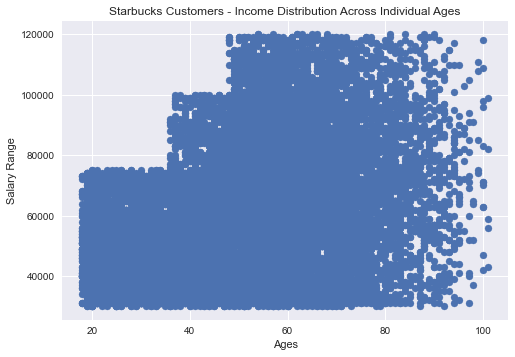

In [32]:
#Visualizing the data in a scatter plot using individual ages instead of age ranges
plt.scatter(data = profile, x = 'age', y = 'income');
plt.title('Starbucks Customers - Income Distribution Across Individual Ages');
plt.xlabel('Ages');
plt.ylabel('Salary Range');
plt.style.use('seaborn');

### Answer 2: Analysis of Income Distribution

The violin plots shows that older customers tend to make more money. However, seems that to be a hard cap on the salary range of younger people.<br>
Scatter plot using individual ages shows that there are caps on everybody's salaries.

### Question 3: What we see about correlation between number of days an offer has been open vs. final transaction amount?

Here I expect to see if a offer deadline cause a final transaction. Something like "Well, I gotta use it or lose it". But maybe we couldn't see correlations here.

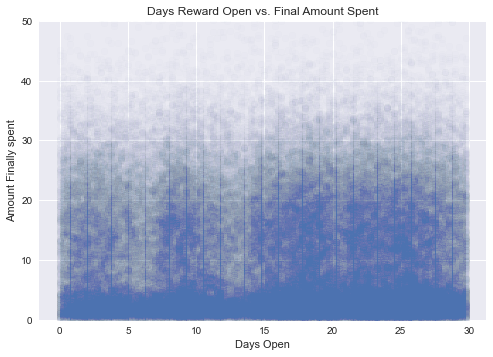

In [33]:
#Visualizing the days open vs amount spent in a scatter plot with alpha, it help to see where points are more frequent
plt.scatter(data = transcript_amount, x = 'days', y = 'amount', alpha = .01);
plt.title('Days Reward Open vs. Final Amount Spent');
plt.xlabel('Days Open');
plt.ylabel('Amount Finally spent');
plt.style.use('seaborn');
plt.ylim(0,50);

### Answer 3: Analysis of Amount Spent vs. Days Open
We can see that when the offer are close to 30 days deadline, more people tend to spend more money in final transaction, but it's a little irrelevant so there is no correlation at all between days open and amount spent.

### Question 4: Do gender distributions have any major effect on data here?

Finally, how gender may affect the final analysis.<br>
F: Female<br>M: Male<br>O: Other

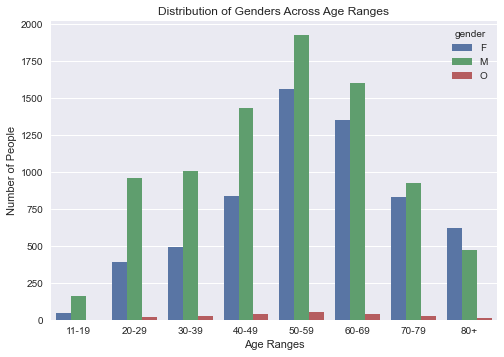

In [34]:
#Visualizing the gender distribution
sb.countplot(data = profile, x = 'age_range', hue = 'gender');
plt.title('Distribution of Genders Across Age Ranges');
plt.xlabel('Age Ranges');
plt.ylabel('Number of People');
plt.style.use('seaborn');

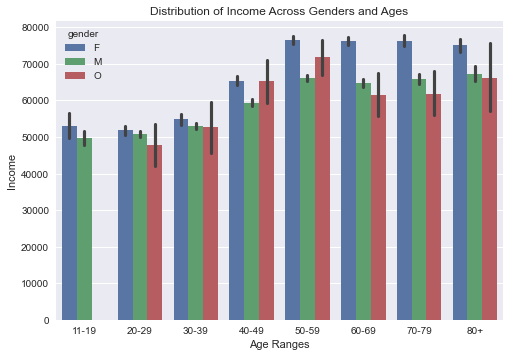

In [35]:
#Visualizing the gender/income/age range distribution
sb.barplot(data = profile, x = 'age_range', y = 'income', hue = 'gender');
plt.title('Distribution of Income Across Genders and Ages');
plt.xlabel('Age Ranges');
plt.ylabel('Income');
plt.style.use('seaborn');

### Answer 4: Analysis of gender across our customer data

First, we see more males across this dataset than any other gender category. The only age range we see more women is in the 80+ category. My guess is the fact that women generally tend to live longer than men.
<br>
Something really interesting here is the salary distribution for women in particular. Where the dataset indicates that there are more male customers than female (or other) customers, females in this dataset generally tend to have a higher income than men. And across both the primary genders, it's not as if there's a crazy disparity between the average salary, too. 

### Customer Transactions

We're now going to create a function that builds a 'customer_transactions' dataframe. I'll to engineer some new feature that I feel will be helpful when we actually move toward build ML models.<br>Each row will represent an individual customer and contain the following columns / features.

#### Features:
 - **customer_id**: The unique customer identifier
 - **age**: The age of the customer
 - **age_range**: The age range the customer falls into
 - **gender**: The gender of the customer, either male (M), female (F), or other (O), that I'll categorize to 1-2-3
 - **income**: How much money the customer makes each year
 - **became_member_on**: The date that the customer because a Starbucks Rewards member
 - **days_as_member**: How many days that the customer has been a Starbucks Rewards member
 - **total_completed**: The total number of offers actually completed by the customer
 - **total_received**: The total number of offers that Starbucks sent to the customer
 - **total_viewed**: The total number of offers that the customer viewed
 - **percent_completed**: The ratio of offers that the customer completed as compared to how many offers Starbucks sent to the customer
 - **total_spent**: The total amount of money spent by the customer across all transactions
 - **avg_spent**: The mean average amount of money spent by the customer across all transactions
 - **num_transactions**: The total amount of individual monetary transactions performed by the customer
 - **completed_bogo**: The number of completed BOGO offers by the customer
 - **num_bogos**: The total number of BOGO offers sent to the customer by Starbucks
 - **bogo_percent_completed**: The ratio of how many BOGO offers were actually completed by the customer as compared to how many Starbucks sent them
 - **completed_discount**: The number of completed discount offers by the customer
 - **num_discounts**: The number of discount offers sent to the customer by Starbucks
 - **discount_percent_completed**: The ratio of how many discount offers were actually completed by the customer as compared to how many Starbucks sent them

In [36]:
#Creating a function that will build our master DataFrame_customer transactions
def generate_transactions(customer_ids, portfolio = portfolio, profile = profile, transcript_offer = transcript_offer, transcript_amount = transcript_amount):
    
    #Initializing a list to append our individual customer dictionaries to
    person_entries = []
    
    for customer_id in tqdm(customer_ids):
        #Pulling customer attributes from the 'profile' DataFrame
        customer_attributes = profile[profile['customer_id'] == customer_id]
        age = customer_attributes['age'].values[0]
        became_member_on = customer_attributes['became_member_on'].values[0]
        gender = customer_attributes['gender'].values[0]
        income = customer_attributes['income'].values[0]
        days_as_member = customer_attributes['days_as_member'].values[0]
        age_range = customer_attributes['age_range'].values[0]

        #Initializing variables we will use later on down
        customer_transactions = pd.DataFrame()
        num_discounts = 0
        num_bogos = 0

        #Establishing new features from respective transcript_offer and transcript_amount DataFrames
        total_viewed = transcript_offer[transcript_offer['customer_id'] == customer_id]['offer_viewed'].sum()
        total_received = transcript_offer[transcript_offer['customer_id'] == customer_id]['offer_received'].sum()
        total_completed = transcript_offer[transcript_offer['customer_id'] == customer_id]['offer_completed'].sum()
        total_spent = transcript_amount[transcript_amount['customer_id'] == customer_id]['amount'].sum()
        avg_spent = transcript_amount[transcript_amount['customer_id'] == customer_id]['amount'].mean()
        num_transactions = transcript_amount[transcript_amount['customer_id'] == customer_id]['transaction'].sum()

        #Determining percentage of completed bogo and discount offers
       
        if total_viewed.sum() > 0:
            percent_completed = total_completed / total_received
        else:
            percent_completed = 0

        #Determining the completed offers in order to determine the completed bogos and completed discounts
        offer_completed_df = transcript_offer[transcript_offer['customer_id'] == customer_id]
        completed_offer_list = offer_completed_df['offer_id'].tolist()
        completed_bogo = portfolio[portfolio['offer_id'].isin(completed_offer_list)]['offer_bogo'].sum()
        completed_discount = portfolio[portfolio['offer_id'].isin(completed_offer_list)]['offer_discount'].sum()

        #Determining all the offers received by an individual customer
        offers_received = transcript_offer[transcript_offer['customer_id'] == customer_id]['offer_id'].values.tolist()

        #Determining whether or not offer is a bogo or discount offer and incrementing appropriate variables
        for x in offers_received:
            #Iterating through all the bogo offers
            if x in ['ae264e3637204a6fb9bb56bc8210ddfd', '4d5c57ea9a6940dd891ad53e9dbe8da0', '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'f19421c1d4aa40978ebb69ca19b0e20d']:
                num_bogos += 1
            #Iterating through all the discount offers
            elif x in ['0b1e1539f2cc45b7b9fa7c272da2e1d7', '2298d6c36e964ae4a3e7e9706d1fb8c2', 'fafdcd668e3743c1bb461111dcafc2a4', '2906b810c7d4411798c6938adc9daaa5']:
                num_discounts += 1

        #Determining the percentage of bogo & discount offers actually completed versus how many of each were offered
        if num_bogos > 0:
            bogo_percent_completed = completed_bogo / num_bogos
        else:
            bogo_perecent_completed = 0.0

        if num_discounts > 0:
            discount_percent_completed = completed_discount / num_discounts
        else:
            discount_percent_completed = 0.0

        #Adding all features to a unified dictionary, 'person_entry'
        person_entry = {'customer_id': customer_id,
                        'age': age,
                        'age_range': age_range,
                        'gender': gender,
                        'income': income,
                        'became_member_on': became_member_on,
                        'days_as_member': days_as_member,
                        'total_completed': total_completed.sum(),
                        'total_viewed': total_viewed.sum(),
                        'total_received': total_received.sum(),
                        'percent_completed': percent_completed,
                        'total_spent': total_spent,
                        'avg_spent': avg_spent,
                        'num_transactions': num_transactions.sum(),
                        'completed_bogo': completed_bogo,
                        'num_bogos': num_bogos,
                        'bogo_percent_completed': bogo_percent_completed,
                        'completed_discount': completed_discount,
                        'num_discounts': num_discounts,
                        'discount_percent_completed': discount_percent_completed}

        #Appending person_entry to master customer_transactions DataFrame
        person_entries.append(person_entry)
    
    #Building our final DataFrame from the person_entries list
    customer_transactions = pd.DataFrame(person_entries)
    customer_transactions['gender'].replace({'M': 0, 'F': 1, 'O': 2}, inplace=True)
    return customer_transactions

### WARNING
The following cell to actually build this master dataset took my personal laptop, a 2018 MacBook Pro, almost 45 minutes to build. Please note this may take your machine a long time to process.

In [37]:
#Generating a list of customer ids to iterate through
customer_ids = profile['customer_id'].to_list()

#Iterate through customer IDs to form master customer_transactions DataFrame
customer_transactions = generate_transactions(customer_ids, portfolio)
customer_transactions.head()

100%|██████████████████████████████████████████████████████████████████| 14825/14825 [33:34<00:00,  7.36it/s]


,customer_id,age,age_range,gender,income,became_member_on,days_as_member,total_completed,total_viewed,total_received,percent_completed,total_spent,avg_spent,num_transactions,completed_bogo,num_bogos,bogo_percent_completed,completed_discount,num_discounts,discount_percent_completed
0,0610b486422d4921ae7d2bf64640c50b,55,50-59,1,112000.0,2017-07-15,382,1,0,2,0.000000,77.01,25.670000,3,1,2,0.500000,0,0,0.000000
1,78afa995795e4d85b5d9ceeca43f5fef,75,70-79,1,100000.0,2017-05-09,449,3,4,4,0.750000,159.27,22.752857,7,3,9,0.333333,0,0,0.000000
2,e2127556f4f64592b11af22de27a7932,68,60-69,0,70000.0,2018-04-26,97,2,3,4,0.500000,57.73,19.243333,3,1,3,0.333333,2,5,0.400000
3,389bc3fa690240e798340f5a15918d5c,65,60-69,0,53000.0,2018-02-09,173,5,6,6,0.833333,36.43,12.143333,3,2,11,0.181818,2,6,0.333333
4,2eeac8d8feae4a8cad5a6af0499a211d,58,50-59,0,51000.0,2017-11-11,263,1,2,3,0.333333,15.62,3.905000,4,0,0,0.181818,2,5,0.400000


In [38]:
#Saving to CSV to avoid reprocessment :)
customer_transactions.to_csv('customer_transactions.csv', index = False)

In [39]:
#Reading back in from CSV
customer_transactions = pd.read_csv('customer_transactions.csv')

## Machine Learning Modeling

As noted in the proposal for this project, I'll leverage some unsupervised algorithms to cluster data to find commonalities across customer segments based on a number of features.

### Feature Selection

At now we need to remove some columns that can't scale or column ids:

 - **customer_id**: proprietary to the row, it is a wholly unique value
 - **became_member_on**: a date column that can't be scaled
 - **age_range**: a categorical column that can't be scaled

In [40]:
#Dropping columns
#Filling in avg_amount null values with Imputer
cols_to_drop = ['customer_id', 'became_member_on', 'age_range']
customer_transactions.drop(columns = cols_to_drop, inplace = True)
customer_transactions.head()

,age,gender,income,days_as_member,total_completed,total_viewed,total_received,percent_completed,total_spent,avg_spent,num_transactions,completed_bogo,num_bogos,bogo_percent_completed,completed_discount,num_discounts,discount_percent_completed
0,55,1,112000.0,382,1,0,2,0.000000,77.01,25.670000,3,1,2,0.500000,0,0,0.000000
1,75,1,100000.0,449,3,4,4,0.750000,159.27,22.752857,7,3,9,0.333333,0,0,0.000000
2,68,0,70000.0,97,2,3,4,0.500000,57.73,19.243333,3,1,3,0.333333,2,5,0.400000
3,65,0,53000.0,173,5,6,6,0.833333,36.43,12.143333,3,2,11,0.181818,2,6,0.333333
4,58,0,51000.0,263,1,2,3,0.333333,15.62,3.905000,4,0,0,0.181818,2,5,0.400000


### Hierarchical Clustering - Feature Tunning

Let's create a single-link based hierarchical model utilizing our unscaled dataset with a choice of six clusters.

In [41]:
column_names = customer_transactions.columns.values.tolist()
imputer = SimpleImputer(strategy = 'median')
customer_transactions = pd.DataFrame(imputer.fit_transform(customer_transactions))
customer_transactions.columns = column_names
customer_transactions.head()

,age,gender,income,days_as_member,total_completed,total_viewed,total_received,percent_completed,total_spent,avg_spent,num_transactions,completed_bogo,num_bogos,bogo_percent_completed,completed_discount,num_discounts,discount_percent_completed
0,55.0,1.0,112000.0,382.0,1.0,0.0,2.0,0.000000,77.01,25.670000,3.0,1.0,2.0,0.500000,0.0,0.0,0.000000
1,75.0,1.0,100000.0,449.0,3.0,4.0,4.0,0.750000,159.27,22.752857,7.0,3.0,9.0,0.333333,0.0,0.0,0.000000
2,68.0,0.0,70000.0,97.0,2.0,3.0,4.0,0.500000,57.73,19.243333,3.0,1.0,3.0,0.333333,2.0,5.0,0.400000
3,65.0,0.0,53000.0,173.0,5.0,6.0,6.0,0.833333,36.43,12.143333,3.0,2.0,11.0,0.181818,2.0,6.0,0.333333
4,58.0,0.0,51000.0,263.0,1.0,2.0,3.0,0.333333,15.62,3.905000,4.0,0.0,0.0,0.181818,2.0,5.0,0.400000


In [42]:
#Using the single_link_model, we'll append the results as a new column to customer_transactions dataset
single_link_model = AgglomerativeClustering(n_clusters = 6, linkage = 'single')
customer_transactions['single_link_cluster'] = single_link_model.fit_predict(customer_transactions)

In [43]:
customer_transactions.head()

,age,gender,income,days_as_member,total_completed,total_viewed,total_received,percent_completed,total_spent,avg_spent,num_transactions,completed_bogo,num_bogos,bogo_percent_completed,completed_discount,num_discounts,discount_percent_completed,single_link_cluster
0,55.0,1.0,112000.0,382.0,1.0,0.0,2.0,0.000000,77.01,25.670000,3.0,1.0,2.0,0.500000,0.0,0.0,0.000000,1
1,75.0,1.0,100000.0,449.0,3.0,4.0,4.0,0.750000,159.27,22.752857,7.0,3.0,9.0,0.333333,0.0,0.0,0.000000,5
2,68.0,0.0,70000.0,97.0,2.0,3.0,4.0,0.500000,57.73,19.243333,3.0,1.0,3.0,0.333333,2.0,5.0,0.400000,5
3,65.0,0.0,53000.0,173.0,5.0,6.0,6.0,0.833333,36.43,12.143333,3.0,2.0,11.0,0.181818,2.0,6.0,0.333333,5
4,58.0,0.0,51000.0,263.0,1.0,2.0,3.0,0.333333,15.62,3.905000,4.0,0.0,0.0,0.181818,2.0,5.0,0.400000,5


## Refinement
 In this section, we'll see a few ways we can optimize our model.

### Feature Scaling

Let's normalize the data for optimal results using scikit-learn's StandardScaler.

In [44]:
#Scaling the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_transactions)
scaled_data

array([[ 0.03488876,  1.06355702,  2.15741893, ..., -1.45171604,
        -1.58581046, -4.17258093],
       [ 1.18543027,  1.06355702,  1.60180089, ..., -1.45171604,
        -1.58581046,  0.2397385 ],
       [ 0.78274074, -0.84253979,  0.2127558 , ...,  0.2752415 ,
         0.12791777,  0.2397385 ],
       ...,
       [-0.31027369, -0.84253979,  0.35166031, ..., -1.10632453,
         2.69851011,  0.2397385 ],
       [ 1.64564687,  1.06355702, -0.71327427, ..., -1.45171604,
        -1.58581046,  0.2397385 ],
       [ 0.43757829,  1.06355702,  0.76837384, ..., -0.41554151,
        -0.1577036 ,  0.2397385 ]])

In [45]:
#Rebuilding the DataFrame
column_names = customer_transactions.columns.values.tolist()
customer_transactions_normalized = pd.DataFrame(scaled_data, columns = column_names)
customer_transactions_normalized.head()

,age,gender,income,days_as_member,total_completed,total_viewed,total_received,percent_completed,total_spent,avg_spent,num_transactions,completed_bogo,num_bogos,bogo_percent_completed,completed_discount,num_discounts,discount_percent_completed,single_link_cluster
0,0.034889,1.063557,2.157419,-0.349433,-0.751176,-2.604592,-2.313047,-1.459474,-0.307925,0.638206,-1.034512,-0.564000,-0.799711,0.672734,-1.711274,-1.451716,-1.585810,-4.172581
1,1.185430,1.063557,1.601801,-0.189601,0.512935,0.493128,-0.451989,0.797646,0.325036,0.459859,-0.262682,1.746709,1.628034,-0.378410,-1.711274,-1.451716,-1.585810,0.239739
2,0.782741,-0.842540,0.212756,-1.029314,-0.119121,-0.281302,-0.451989,0.045273,-0.456278,0.245295,-1.034512,-0.564000,-0.452891,-0.378410,0.582649,0.275242,0.127918,0.239739
3,0.610160,-0.842540,-0.574370,-0.848012,1.777046,2.041988,1.409069,1.048437,-0.620174,-0.188782,-1.034512,0.591354,2.321675,-1.333996,0.582649,0.620633,-0.157704,0.239739
4,0.207470,-0.842540,-0.666973,-0.633313,-0.751176,-1.055732,-1.382518,-0.456309,-0.780299,-0.692454,-0.841554,-1.719354,-1.493353,-1.333996,0.582649,0.275242,0.127918,0.239739


In [46]:
customer_transactions_normalized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14825 entries, 0 to 14824
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   age                         14825 non-null  float64
 1   gender                      14825 non-null  float64
 2   income                      14825 non-null  float64
 3   days_as_member              14825 non-null  float64
 4   total_completed             14825 non-null  float64
 5   total_viewed                14825 non-null  float64
 6   total_received              14825 non-null  float64
 7   percent_completed           14825 non-null  float64
 8   total_spent                 14825 non-null  float64
 9   avg_spent                   14825 non-null  float64
 10  num_transactions            14825 non-null  float64
 11  completed_bogo              14825 non-null  float64
 12  num_bogos                   14825 non-null  float64
 13  bogo_percent_completed      148

In [47]:
#Saving scaled data
customer_transactions_normalized.to_csv('customer_transactions_normalized.csv', index = False)

#### Number of Clusters
Let's determine the number of ideal clusters by viewing KMeans SSE scores as K increases, known as elbow method, as well as leveraging the silhouette score.

In [48]:
#Building a function to quickly iterate through various KMeans models 
#Returns the appropriate k_means score
def kmeans_score(data, n_clusters):
    kmeans = KMeans(n_clusters = n_clusters)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score

In [49]:
#Running the kmeans_score function for a number of different cluster patterns
scores = []
for i in range(1, 20):
    score = kmeans_score(customer_transactions_normalized, i)
    scores.append(score)

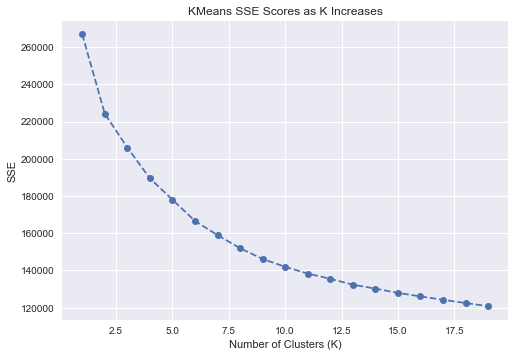

In [50]:
#Plotting results from the previous cell; noting that we begin seeing after about 6 clusters
centers = range(1, 20)
plt.plot(centers, scores, linestyle = '--', marker = 'o');
plt.style.use('seaborn');
plt.title('KMeans SSE Scores as K Increases');
plt.ylabel('SSE');
plt.xlabel('Number of Clusters (K)');

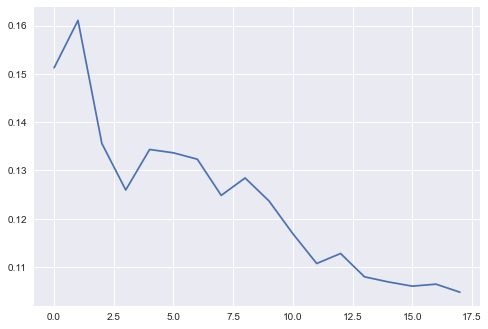

In [51]:
#Determining the silhouette score for the first 20 clusters
silhouette_avg_list = []
for i in range(2, 20):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(customer_transactions_normalized)
    clusters = kmeans.predict(customer_transactions_normalized)
    silhouette_avg = silhouette_score(customer_transactions_normalized, clusters)
    silhouette_avg_list.append(silhouette_avg)
plt.plot(silhouette_avg_list)    
#     print("For n_clusters = ", i,"The avg silhouette_score is :", silhouette_avg)

#### Number of Clusters We Will Use: 4

Given both plots here, we'll use 4 clusters. Both the sihouette score and elbow method started showing diminishing returns following 4 clusters.

## Machine Learning Modeling - Model Tunning

Now we've determined how to properly refine the model to optimize the results and extract some insights.

In [52]:
#Using the ward model, we'll append the results as a new column to our normalized master
ward_model = AgglomerativeClustering(n_clusters = 4)
customer_transactions_normalized['cluster'] = ward_model.fit_predict(customer_transactions_normalized)

In [53]:
customer_transactions_normalized.sample(10)

,age,gender,income,days_as_member,total_completed,total_viewed,total_received,percent_completed,total_spent,avg_spent,num_transactions,completed_bogo,num_bogos,bogo_percent_completed,completed_discount,num_discounts,discount_percent_completed,single_link_cluster,cluster
11335,-1.978559,-0.842540,0.073851,-0.685795,-0.119121,0.493128,1.409069,-0.456309,-0.538303,-0.751337,1.473934,0.591354,2.321675,-1.333996,-1.711274,-1.451716,-1.585810,0.239739,2
13787,2.681134,1.063557,-0.296561,-0.044083,-0.751176,-0.281302,-1.382518,-0.456309,0.419526,0.117620,0.316190,-1.719354,-1.493353,0.042047,-0.564313,-0.415542,-0.157704,0.239739,1
2699,-1.575869,-0.842540,-1.500400,2.670670,1.777046,1.267558,1.409069,1.048437,-0.206202,-0.773583,5.140123,1.746709,2.321675,-0.760645,0.582649,0.275242,0.127918,0.239739,2
90,0.149943,1.063557,2.250022,-0.323192,1.777046,1.267558,1.409069,1.048437,0.521634,0.481236,-0.069725,1.746709,2.668496,-0.903983,-0.564313,-0.415542,-0.157704,-4.172581,0
6884,0.782741,1.063557,0.397962,0.060882,-0.751176,-1.830162,-2.313047,0.045273,-0.544304,0.012157,-1.034512,-1.719354,-1.493353,1.303421,0.582649,-0.070150,0.556350,0.239739,1
4240,-0.137692,-0.842540,1.601801,0.611943,1.144990,2.041988,1.409069,0.546855,0.575111,0.534349,-0.069725,0.591354,0.587572,-0.378410,-0.564313,0.620633,-0.871757,0.239739,2
7980,-0.482855,-0.842540,-1.315194,-0.561746,-0.751176,-1.055732,-0.451989,-0.707101,-0.768603,-0.669221,-0.841554,-0.564000,-0.452891,-0.378410,1.729610,-0.070150,1.627430,0.239739,1
2877,1.818228,-0.842540,0.351660,-0.793144,-0.751176,-1.055732,-1.382518,-0.456309,-0.797073,-0.725774,-0.841554,-0.564000,-0.799711,0.672734,-0.564313,-0.415542,-0.157704,0.239739,1
10369,-0.540382,-0.842540,0.860977,0.635798,0.512935,0.493128,-0.451989,0.797646,0.365048,0.325717,-0.069725,-0.564000,0.587572,-1.429555,-0.564313,-0.415542,-0.157704,0.239739,2
10027,-0.482855,1.063557,-0.157656,-0.067938,1.777046,-0.281302,0.478540,1.550019,1.961223,0.057399,2.824635,-0.564000,-0.452891,-0.378410,0.582649,2.002199,-0.728946,0.239739,2


In [54]:
#Adding our clusters column back into our primary, unnormalized dataset for analyses
customer_transactions['cluster'] = customer_transactions_normalized['cluster']

In [55]:
customer_transactions.to_csv('customer_transactions_clusters.csv', index = False)

In [56]:
customer_transactions = pd.read_csv('customer_transactions_clusters.csv')

In [57]:
customer_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14825 entries, 0 to 14824
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   age                         14825 non-null  float64
 1   gender                      14825 non-null  float64
 2   income                      14825 non-null  float64
 3   days_as_member              14825 non-null  float64
 4   total_completed             14825 non-null  float64
 5   total_viewed                14825 non-null  float64
 6   total_received              14825 non-null  float64
 7   percent_completed           14825 non-null  float64
 8   total_spent                 14825 non-null  float64
 9   avg_spent                   14825 non-null  float64
 10  num_transactions            14825 non-null  float64
 11  completed_bogo              14825 non-null  float64
 12  num_bogos                   14825 non-null  float64
 13  bogo_percent_completed      148

## Final Analysis

Finally we can visualize the results.

### Question 5: What personal attributes of customers are defined throughout each of clusters?

First, let's take a look at the personal attributes of customers as clustered by the algorithm.

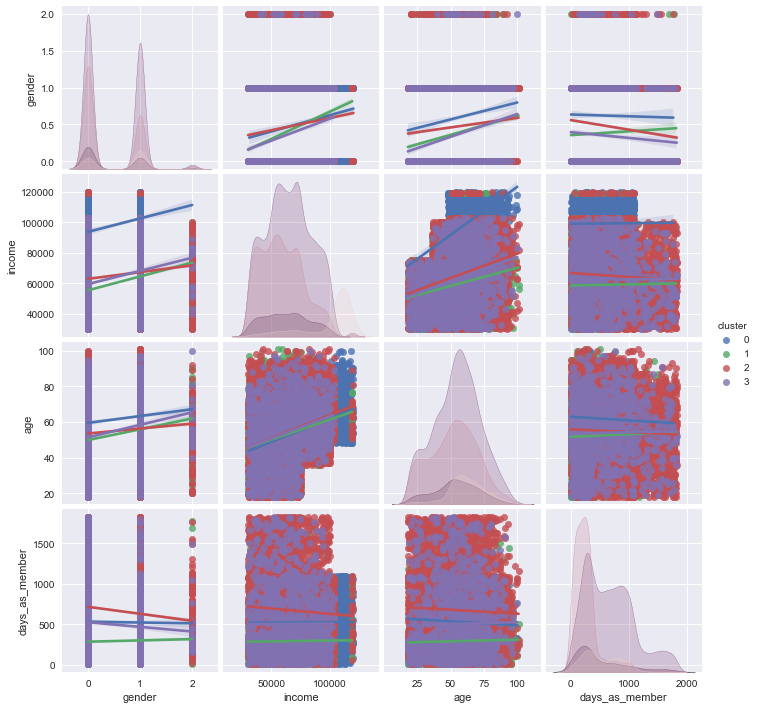

In [58]:
#Viewing personal customer details in a seaborn pairplot
personal_details = ['gender', 'income', 'age', 'days_as_member', 'cluster']
sb.pairplot(customer_transactions[personal_details], hue = 'cluster', kind = 'reg');

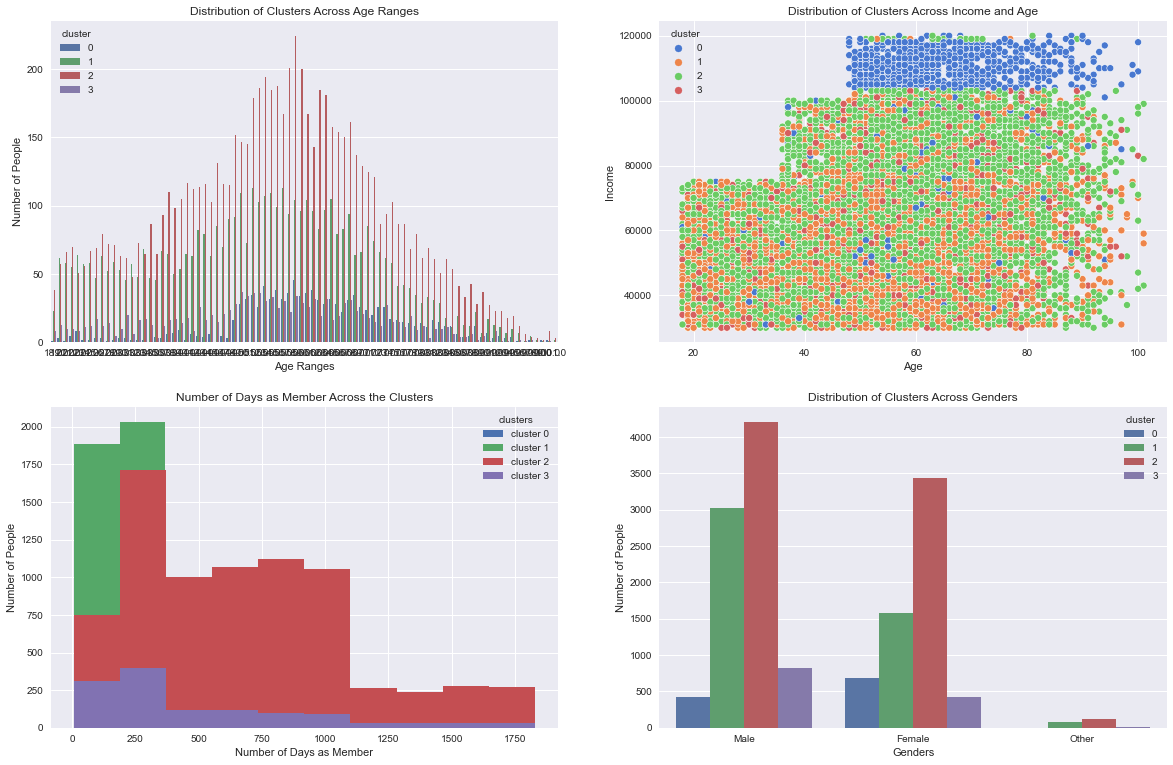

In [59]:
#Visualizing the personal details in closer details across each cluster

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 13))

#Visualizing clusters across age ranges
sb.countplot(data = customer_transactions, x = 'age', hue = 'cluster', ax = axes[0,0]);
axes[0,0].set_title('Distribution of Clusters Across Age Ranges');
axes[0,0].set_xlabel('Age Ranges');
axes[0,0].set_ylabel('Number of People');

#Visualizing clusters across incomes and ages
sb.scatterplot(data = customer_transactions, x = 'age', y = 'income', hue = 'cluster', palette = sb.color_palette('muted', n_colors = 4), ax = axes[0,1]);
axes[0,1].set_title('Distribution of Clusters Across Income and Age');
axes[0,1].set_xlabel('Age');
axes[0,1].set_ylabel('Income');

#Visualizing how long members have been members in a stacked histogram
days_as_member_0 = customer_transactions[customer_transactions['cluster'] == 0]['days_as_member']
days_as_member_1 = customer_transactions[customer_transactions['cluster'] == 1]['days_as_member']
days_as_member_2 = customer_transactions[customer_transactions['cluster'] == 2]['days_as_member']
days_as_member_3 = customer_transactions[customer_transactions['cluster'] == 3]['days_as_member']
axes[1,0].hist(days_as_member_0, stacked = True);
axes[1,0].hist(days_as_member_1, stacked = True);
axes[1,0].hist(days_as_member_2, stacked = True);
axes[1,0].hist(days_as_member_3, stacked = True);
axes[1,0].legend(title = 'clusters', labels = ['cluster 0', 'cluster 1', 'cluster 2', 'cluster 3']);
axes[1,0].set_title('Number of Days as Member Across the Clusters');
axes[1,0].set_xlabel('Number of Days as Member');
axes[1,0].set_ylabel('Number of People');

#Visualizing clusters across age ranges
sb.countplot(data = customer_transactions, x = 'gender', hue = 'cluster', ax = axes[1,1]);
axes[1,1].set_title('Distribution of Clusters Across Genders');
axes[1,1].set_xlabel('Genders');
axes[1,1].set_ylabel('Number of People');
plt.sca(axes[1,1]);
plt.xticks(range(3), ['Male', 'Female', 'Other']);

### Answer 5: Analysis of Clustered Personal Attributes

Now we let's cover each of the respective clusters within the respective sections below.

#### Cluster 0
This is largest cluster, cluster 0 tended to consist of older people with higher incomes. As evidenced by our countplot with the age ranges, the ages typcally fell into that 50 to 80 year old range.

Additionally, it was somewhat common to see these folks have some of the higher income ranges.

Gender was somewhat evenly split between males and females, 

Because this cluster was the biggest, it had a lot of discrepancies (particularly with income) that make it questionable how much to rely upon it for future inference.

#### Cluster 1
This cluster seems to be the young person's cluster.

Looking at the age range distribution, we see the strongest distrubution here amongst the 20-40 year old crowd.

The gap between males and females is quite large in this cluster.

These people also tend to fall toward the lower end when it comes to income.

And as far as number of days as member goes, this cluster's distribution is very similar to that of cluster 0.

#### Cluster 2
This is the only customer where there were more males than females

This cluster contain the largest distribution of people who have been members of the Starbucks rewards program for some time.

Income tended to be higher here which is not surprising given that EDA showed us that women tended to make more than men.

#### Cluster 3
The smallest of four clusters, yet it bears some striking similarites to cluster 0 in a few ways.

Namely, the distribution of days as member and gender are fairly similar. The exception that separates it from cluster 0 is that there tended to be more people in the younger age range.

### Question 6: What do the behavioral attributes look like across our clusters?

Finally, let's look at the clusters across some of the more behavioral attributes.

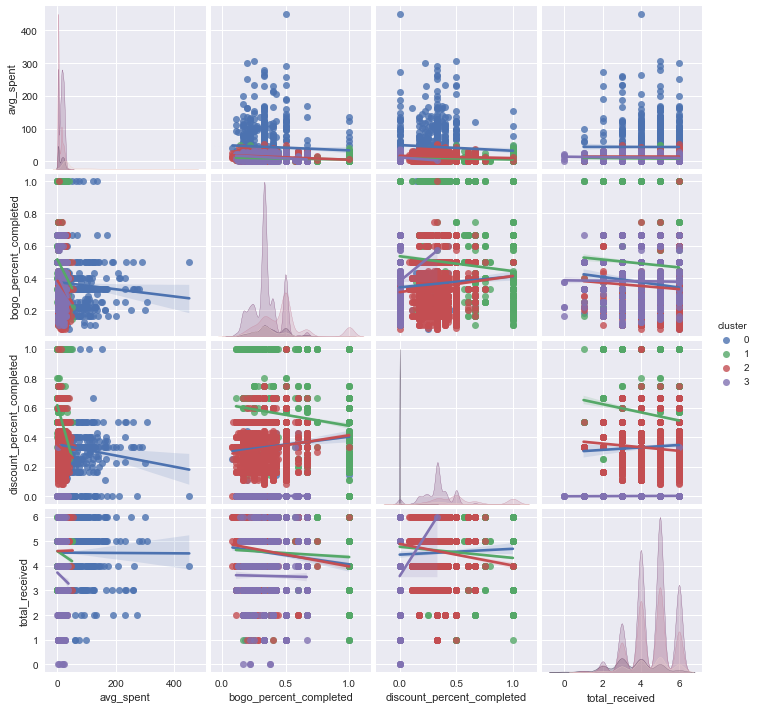

In [60]:
behavioral_attributes = ['cluster', 'avg_spent', 'bogo_percent_completed', 'discount_percent_completed', 'total_received']
sb.pairplot(customer_transactions[behavioral_attributes], hue = 'cluster', kind = 'reg');

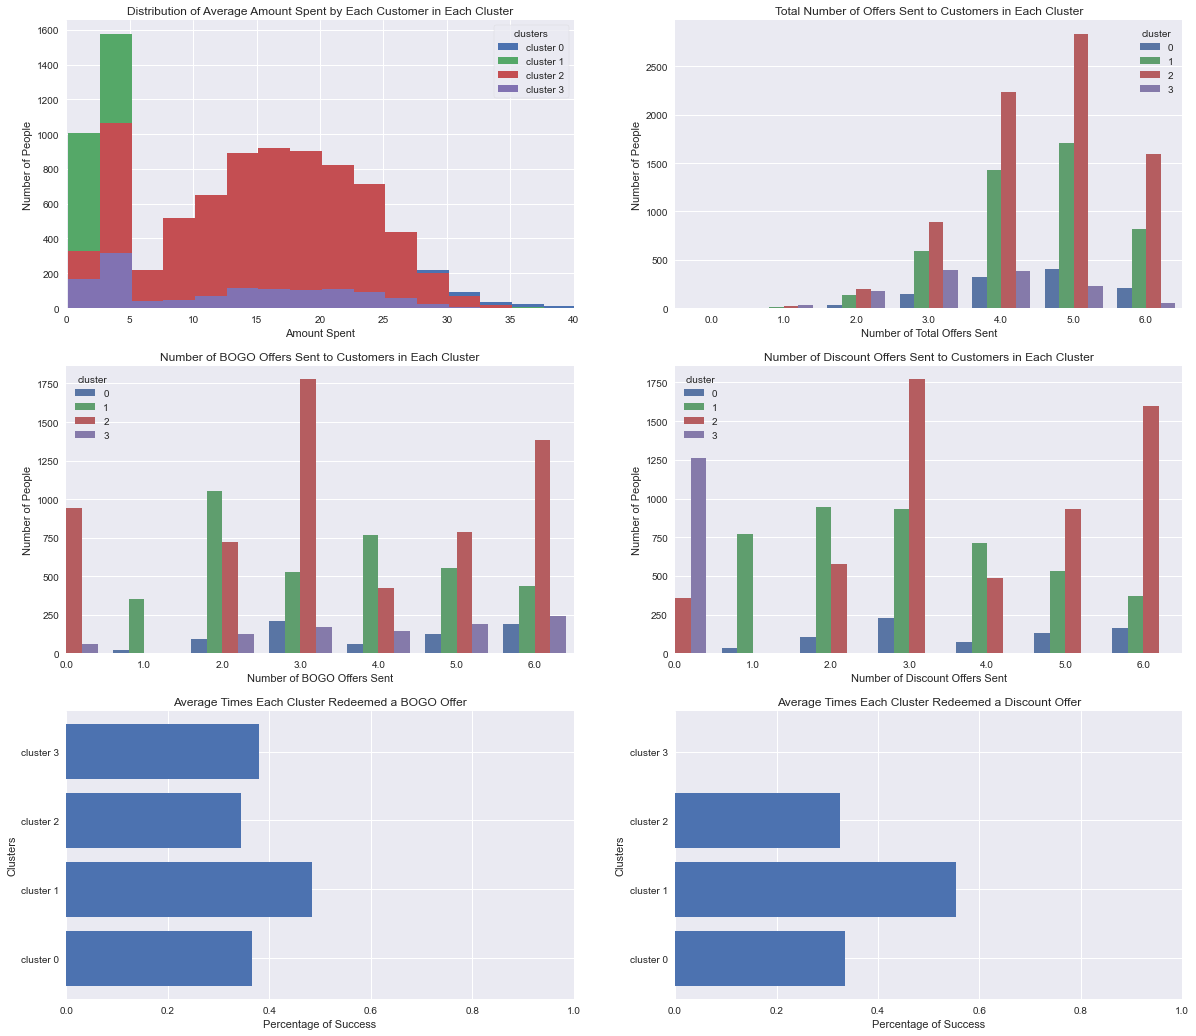

In [61]:
#Visualizing the behavioral attributes in more detail
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (20, 18))

#Visualizing the average amount spent by customers in each respective cluster
avg_spent_0 = customer_transactions[customer_transactions['cluster'] == 0]['avg_spent']
avg_spent_1 = customer_transactions[customer_transactions['cluster'] == 1]['avg_spent']
avg_spent_2 = customer_transactions[customer_transactions['cluster'] == 2]['avg_spent']
avg_spent_3 = customer_transactions[customer_transactions['cluster'] == 3]['avg_spent']
avg_spent_bins = np.arange(min(customer_transactions['avg_spent']), max(customer_transactions['avg_spent'] + 2.5), 2.5)
axes[0,0].hist(avg_spent_0, bins = avg_spent_bins, stacked = True);
axes[0,0].hist(avg_spent_1, bins = avg_spent_bins, stacked = True);
axes[0,0].hist(avg_spent_2, bins = avg_spent_bins, stacked = True);
axes[0,0].hist(avg_spent_3, bins = avg_spent_bins, stacked = True);
axes[0,0].set_xlim([0, 40]);
axes[0,0].legend(title = 'clusters', labels = ['cluster 0', 'cluster 1', 'cluster 2', 'cluster 3'], frameon = True);
axes[0,0].set_title('Distribution of Average Amount Spent by Each Customer in Each Cluster');
axes[0,0].set_xlabel('Amount Spent');
axes[0,0].set_ylabel('Number of People');

#Visualizing the total number of offers sent to the customers
sb.countplot(data = customer_transactions, x = 'total_received', hue = 'cluster', ax = axes[0,1]);
axes[0,1].set_title('Total Number of Offers Sent to Customers in Each Cluster');
axes[0,1].set_xlabel('Number of Total Offers Sent');
axes[0,1].set_ylabel('Number of People');

#Visualizing the number of BOGO offers sent to the customers
sb.countplot(data = customer_transactions, x = 'num_bogos', hue = 'cluster', ax = axes[1,0]);
axes[1,0].set_title('Number of BOGO Offers Sent to Customers in Each Cluster');
axes[1,0].set_xlabel('Number of BOGO Offers Sent');
axes[1,0].set_ylabel('Number of People');
axes[1,0].set_xlim([0, 6.5]);

#Visualizing the number of discount offers sent to the customers
sb.countplot(data = customer_transactions, x = 'num_discounts', hue = 'cluster', ax = axes[1,1]);
axes[1,1].set_title('Number of Discount Offers Sent to Customers in Each Cluster');
axes[1,1].set_xlabel('Number of Discount Offers Sent');
axes[1,1].set_ylabel('Number of People');
axes[1,1].set_xlim([0, 6.5]);

#Visualizing the mean of the how often customers completed bogo offers in each cluster
bogo_pct_completed_0 = customer_transactions[customer_transactions['cluster'] == 0]['bogo_percent_completed'].mean()
bogo_pct_completed_1 = customer_transactions[customer_transactions['cluster'] == 1]['bogo_percent_completed'].mean()
bogo_pct_completed_2 = customer_transactions[customer_transactions['cluster'] == 2]['bogo_percent_completed'].mean()
bogo_pct_completed_3 = customer_transactions[customer_transactions['cluster'] == 3]['bogo_percent_completed'].mean()
bogo_pct_completed_data = [bogo_pct_completed_0, bogo_pct_completed_1, bogo_pct_completed_2, bogo_pct_completed_3]
y_pos = np.arange(len(bogo_pct_completed_data))
bogo_tick_labels = ['cluster 0', 'cluster 1', 'cluster 2', 'cluster 3']
axes[2,0].barh(y_pos, bogo_pct_completed_data, tick_label = bogo_tick_labels);
axes[2,0].set_xlim([0, 1]);
axes[2,0].set_title('Average Times Each Cluster Redeemed a BOGO Offer');
axes[2,0].set_xlabel('Percentage of Success');
axes[2,0].set_ylabel('Clusters');

#Visualizing the mean of the how often customers completed discount offers in each cluster
discount_pct_completed_0 = customer_transactions[customer_transactions['cluster'] == 0]['discount_percent_completed'].mean()
discount_pct_completed_1 = customer_transactions[customer_transactions['cluster'] == 1]['discount_percent_completed'].mean()
discount_pct_completed_2 = customer_transactions[customer_transactions['cluster'] == 2]['discount_percent_completed'].mean()
discount_pct_completed_3 = customer_transactions[customer_transactions['cluster'] == 3]['discount_percent_completed'].mean()
discount_pct_completed_data = [discount_pct_completed_0, discount_pct_completed_1, discount_pct_completed_2, discount_pct_completed_3]
y_pos = np.arange(len(discount_pct_completed_data))
discount_tick_labels = ['cluster 0', 'cluster 1', 'cluster 2', 'cluster 3']
axes[2,1].barh(y_pos, discount_pct_completed_data, tick_label = discount_tick_labels);
axes[2,1].set_xlim([0, 1]);
axes[2,1].set_title('Average Times Each Cluster Redeemed a Discount Offer');
axes[2,1].set_xlabel('Percentage of Success');
axes[2,1].set_ylabel('Clusters');

### Answer 6: Analysis of Clustered Behavioral Attributes

Let's cover each of the respective clusters within the respective sections below.

#### Cluster 0
This cluster on average seems to be the biggest spenders.

This cluster contains older customers, that maybe are buying for multiple people, like family members.

This cluster has the lowest yield of using discount offers and pretty close to last for BOGO offers.

#### Cluster 1
This cluster tends toward a younger crowd, is possible see things like the average amount spent spike toward the lower end. 
This particular group gets hit hard with offers, spiking big time around 5 offers sent.

It looks like there's a stronger leaning toward BOGO offers over discount offers.

#### Cluster 2
This is predominantly female cluster, this group also has a high spend amount, much akin to cluster 0.

This cluster is hit pretty strongly with a lot of offers, especially BOGO offers.

#### Cluster 3
This cluster group tends a little younger than the cluster 0's.

This group has a high success rate with offers, especially with discount based offers.

This cluster is the smallest of the bunch.